# 0.0 Imports

In [1]:
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt

import matplotlib.pyplot as plt

from boruta import BorutaPy
from sklearn import linear_model as lm
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh


## 0.1 Loading Dataset

In [2]:
df_raw = pd.read_csv('../data/train.csv')

## 0.2 Filter Warnings

In [3]:
warnings.filterwarnings('ignore')

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code','previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
            'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1 Data Dimension

In [6]:
print('Number of Rows: {}' .format(df1.shape[0] ) ) 
print('Number of Columns: {}' .format(df1.shape[1] ) ) 

Number of Rows: 381109
Number of Columns: 12


## 1.2 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Data Descriptive

In [9]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )

In [10]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skev, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 Feature Engineering

In [11]:
df2 = df1.copy()

In [12]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x =='1-2 Year' else 'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# 3.0 Data Featuring

In [13]:
df3 = df2.copy()

# 4.0 EDA

In [14]:
df4 = df3.copy()

## 4.1 Univariate Analysis

<Axes: xlabel='age', ylabel='Count'>

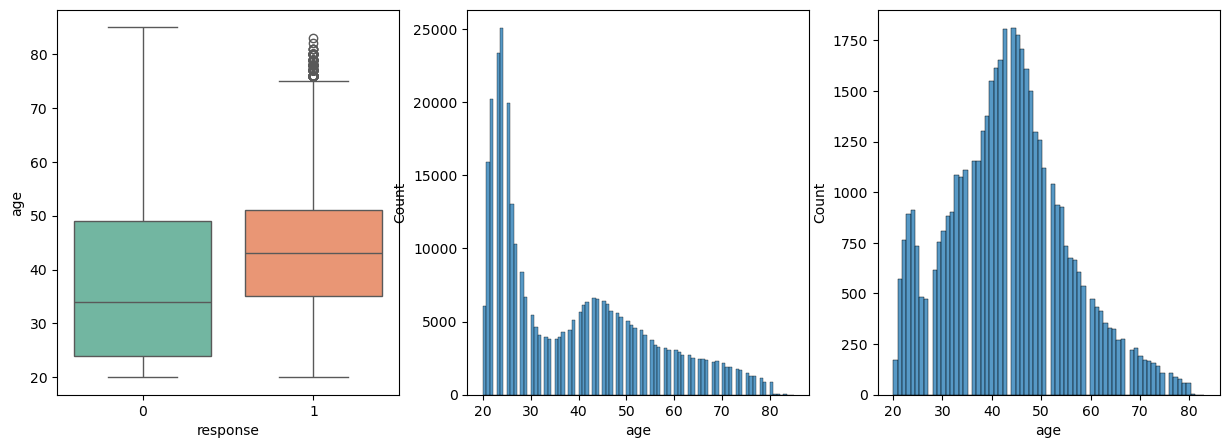

In [15]:
# age
plt.figure(figsize=(15, 5))

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'response', y = 'age', data = df4, palette='Set2');

plt.subplot( 1, 3, 2 )
aux00 = df4.loc[df4['response'] == 0, 'age' ]
sns.histplot( aux00 )

plt.subplot( 1, 3, 3 )
aux00 = df4.loc[df4['response'] == 1, 'age' ]
sns.histplot( aux00 )

<Axes: xlabel='annual_premium', ylabel='Count'>

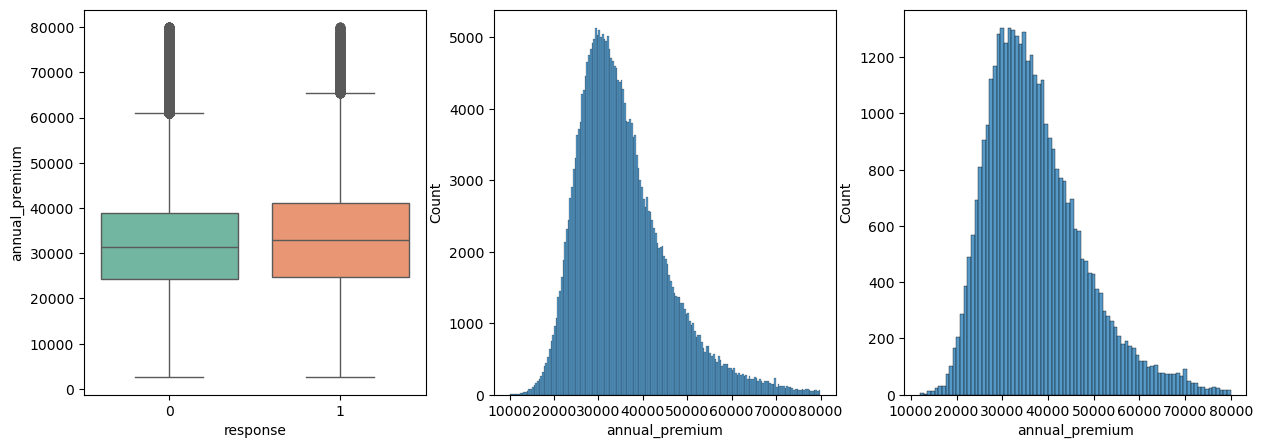

In [16]:
# annual_premium
plt.figure(figsize=(15, 5))

plt.subplot( 1, 3, 1 )
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x = 'response', y = 'annual_premium', data = aux, palette='Set2');
plt.subplot( 1, 3, 2 )

aux = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 0, 'annual_premium' ]
sns.histplot( aux00 )

plt.subplot( 1, 3, 3 )
aux = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 1, 'annual_premium' ]
sns.histplot( aux00 )


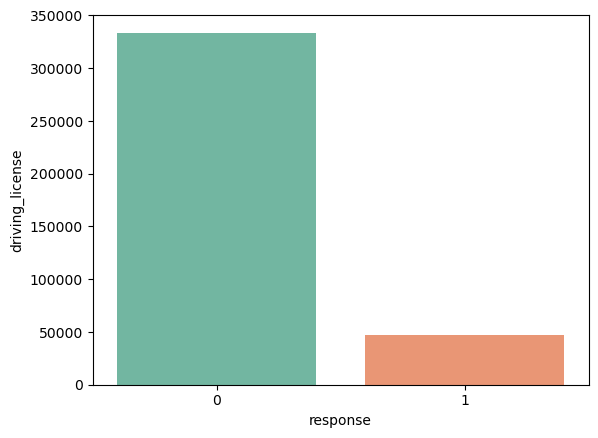

In [17]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license']
sns.barplot( x = 'response', y = 'driving_license', data = aux, palette='Set2' );


<Axes: xlabel='region_code', ylabel='id'>

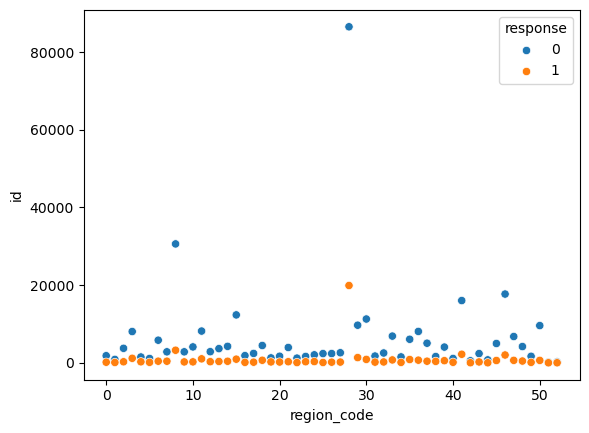

In [18]:
# region_code

aux0 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot( x = 'region_code', y = 'id', hue = 'response', data = aux0  )

In [19]:
# previously_insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [20]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize = True).reset_index()

,vehicle_age,response,proportion
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


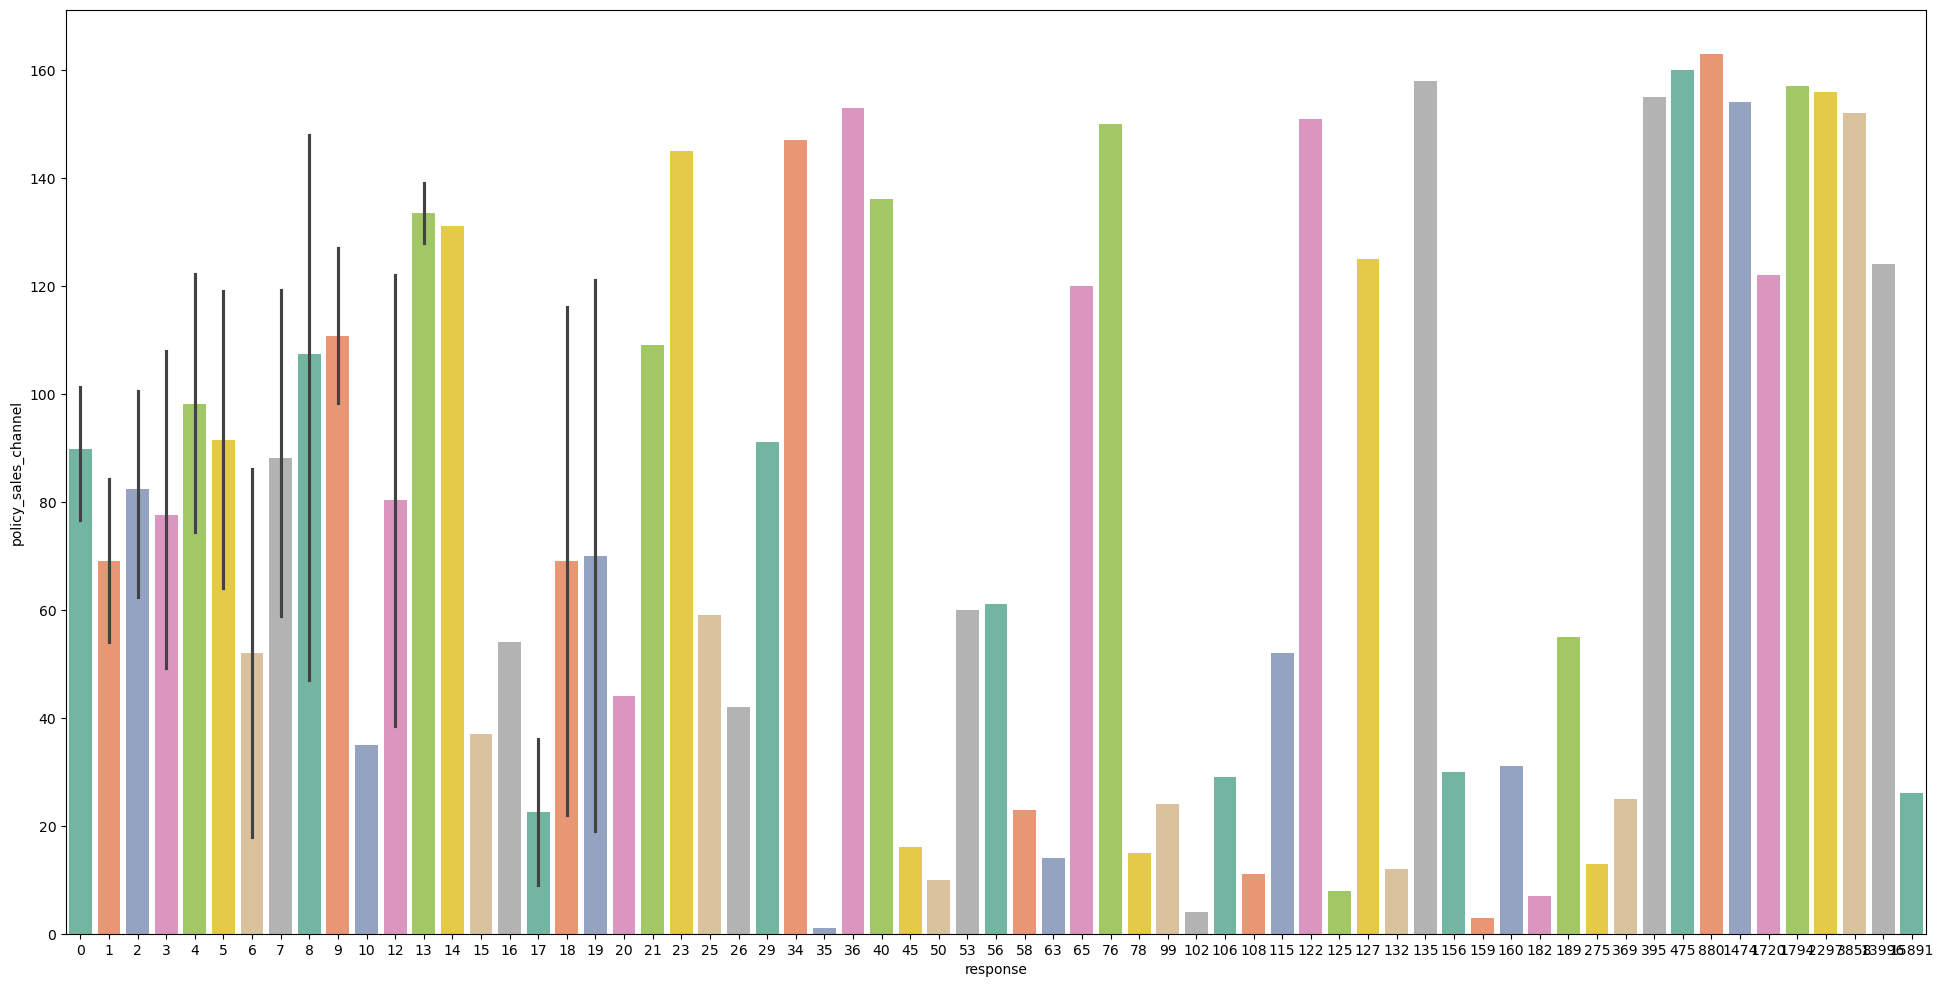

In [21]:
# policy_sales_channel
plt.figure(figsize=(24, 12))
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x = 'response', y = 'policy_sales_channel', data = aux, palette='Set2' );


<Axes: xlabel='vintage', ylabel='Count'>

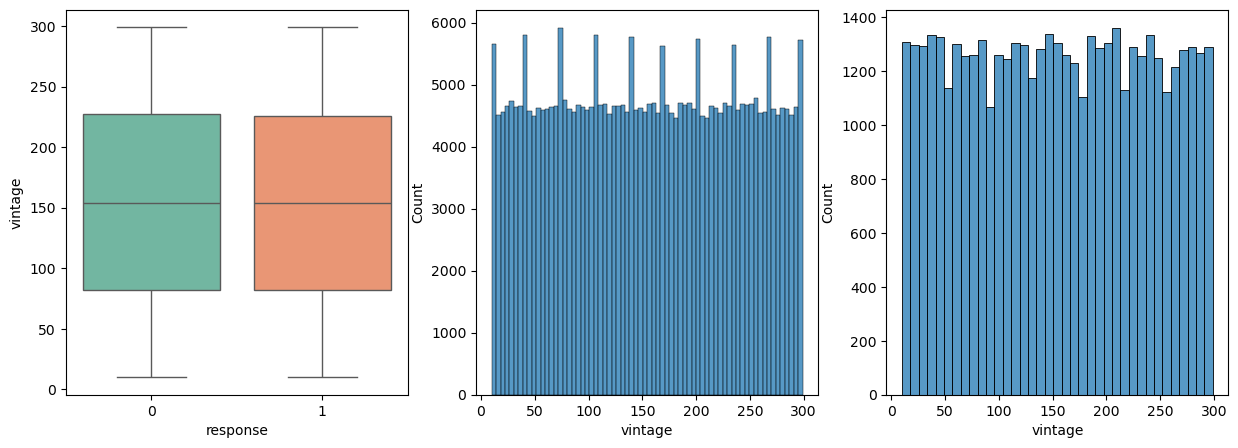

In [22]:
# vintage
plt.figure(figsize=(15, 5))

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'response', y = 'vintage', data = df4, palette='Set2');
plt.subplot( 1, 3, 2 )

aux00 = df4.loc[df4['response'] == 0, 'vintage' ]
sns.histplot( aux00 )

plt.subplot( 1, 3, 3 )
aux00 = df4.loc[df4['response'] == 1, 'vintage' ]
sns.histplot( aux00 )

# 5.0 Data Preparation

In [49]:
df5 = df4.copy()

In [50]:
X = df4.drop('response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y , test_size = 0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1 Standardization

In [51]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values )
pickle.dump( ss, open( '../src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2 Rescaling

In [52]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
# age 
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump( mms_age, open( '../src/features/age_scaler.pkl', 'wb' ) )

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump( mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb' ) )

## 5.3 Encoder

In [53]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Frenquency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '../src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Order Encoding / Frenquency Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump( fe_policy_sales_channel, open( '../src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4 Validation Preparation

In [54]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_encode_gender )

# age 
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code 
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium' ] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation.loc[:, 'policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)


# 6.0 Feature Selection

## 6.1 Boruta

### Modelo apresenta apeans 1 coluna como relevante = 'Age'

In [29]:
# # Training 
# x_train_n = df5.drop( ['id', 'response'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # Define Model
# et = en.ExtraTreesClassifier( n_jobs=-1 )

# # Define Boruta

# boruta = BorutaPy( et, n_estimators='auto', verbose = 2, random_state = 42).fit( x_train_n, y_train_n )

In [30]:
# cols_selected = boruta.support_.tolist()

# # best features

# x_train_fs = df5.drop( ['id', 'response'], axis=1 )
# cols_selected_boruta = x_train_fs.iloc[ :, cols_selected ].columns.to_list()

# # not selected boruta

# cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2. Features Importance

In [31]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
                        feature  importance
0                       vintage    0.271722
0                annual_premium    0.243797
0                           age    0.165492
0                   region_code    0.107667
0                vehicle_damage    0.069038
0          policy_sales_channel    0.059043
0            previously_insured    0.055133
0      vehicle_age_below_1_year    0.013812
0  vehicle_age_between_1_2_year    0.006657
0                        gender    0.004772
0      vehicle_age_over_2_years    0.002394
0               driving_license    0.000475


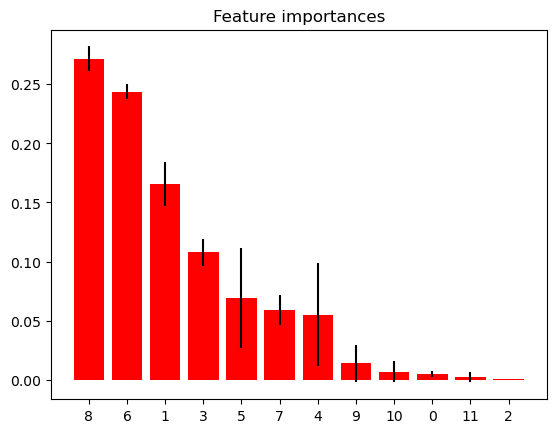

In [32]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking: ')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i , 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0  )

print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 Machine Learning

In [67]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured','policy_sales_channel']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation

## 7.1 KNN

In [77]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train)

# model prediction - Poder de generalização
yhat_knn = knn_model.predict_proba( x_val )

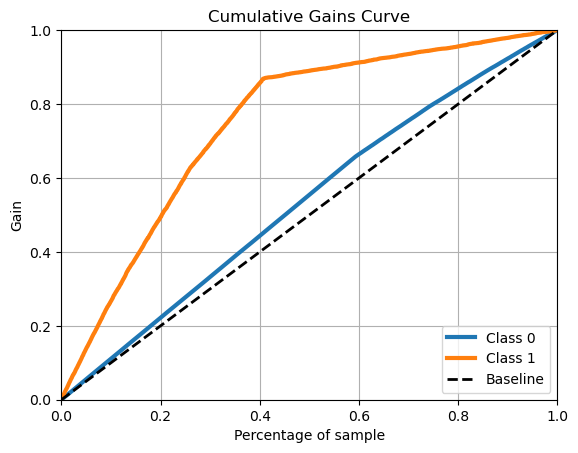

In [78]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

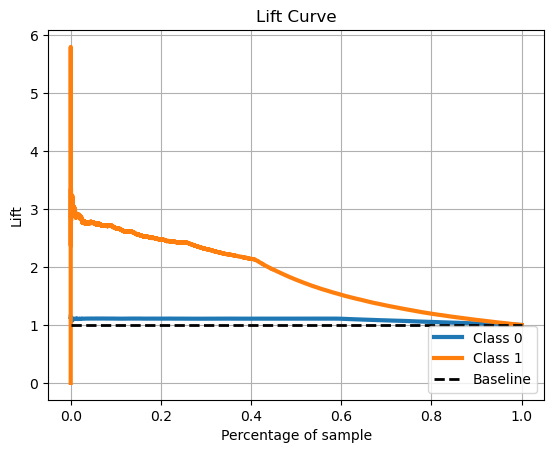

In [79]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

## 7.2 Logistic Regression

In [71]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42 )

# model training
lr_model.fit( x_train, y_train )

# model predict
yhat_lr = lr_model.predict_proba( x_val )

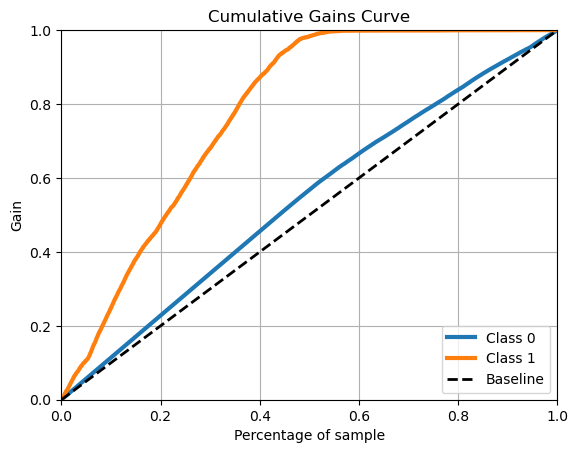

In [72]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

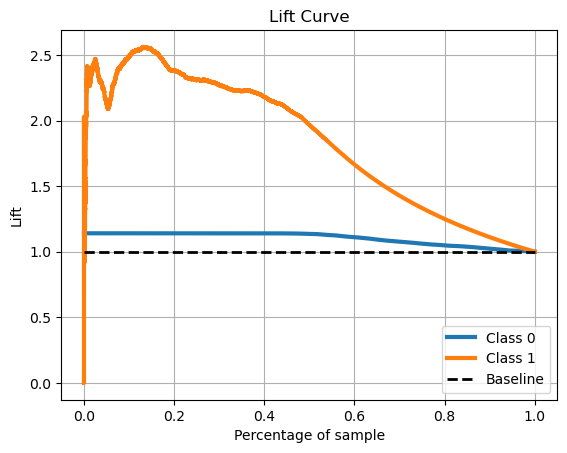

In [73]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 7.3 Extra Trees

In [74]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model training
et.fit( x_train, y_train )

# model prediction
yhat_et = et.predict_proba( x_val )


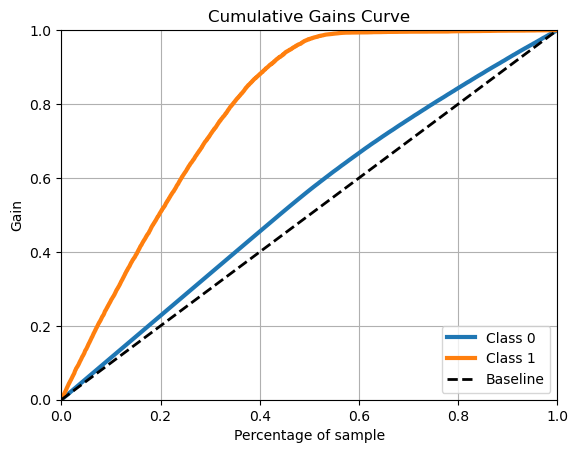

In [75]:
# Accumlative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

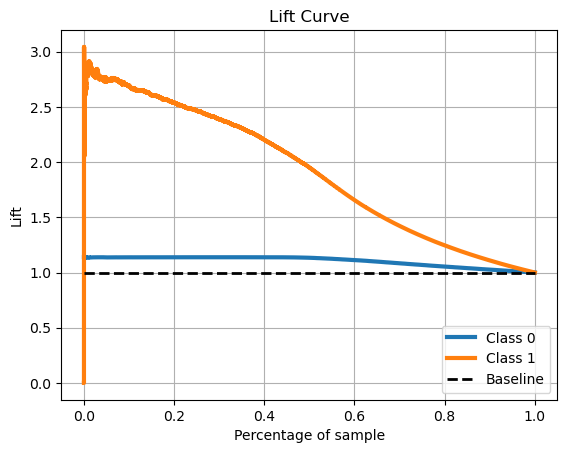

In [76]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_et );

## 7.4 Random Forest

In [43]:
# model definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = et.predict_proba( x_val )

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

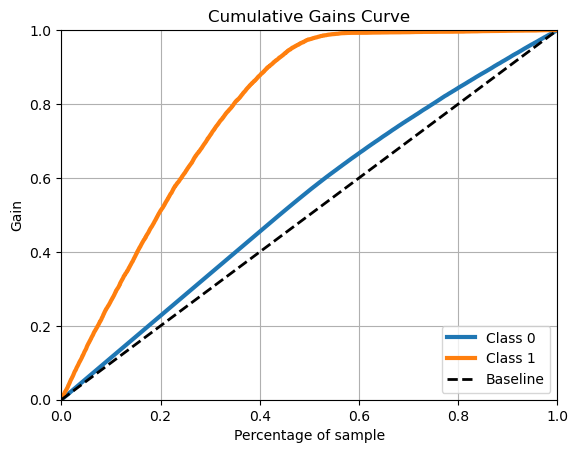

In [44]:
# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf )

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

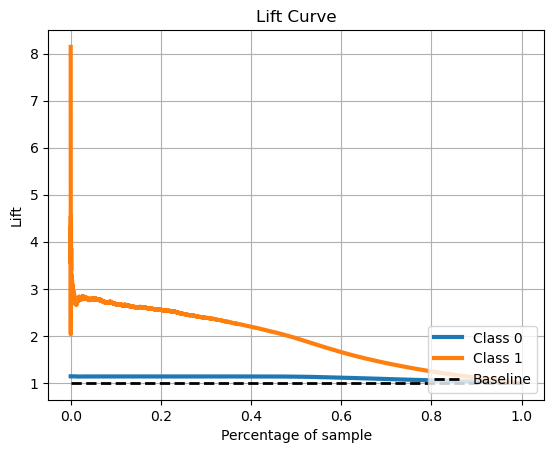

In [45]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_rf )

# 8.0 Model Performance

In [109]:
def precision_at_k ( data, k=10 ):
    data = data.reset_index( drop = True )
    # Create ranking order
    data['ranking'] = data.index +1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return ( data.loc[ k, 'precision_at_k'], data )

In [110]:
def recall_at_k ( data, k = 15):
    data = data.reset_index( drop = True)
    # Create ranking order
    data['ranking'] = data.index +1

    data['recall_at_k'] = data['response'].cumsum() / data['ranking']

    return ( data.loc[ k, 'recall_at_k'], data )

In [111]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending = False )

# compute precision at k
precision_at_20, data = precision_at_k( df8, k=20 )

# compute recall at k
recall_at_15, data = recall_at_k( df8, k=15 )